# Make starless images

This is meant to be run on data that have been through BrA_Separation, I think

In [1]:
from astropy.io import fits
import numpy as np

In [2]:
%matplotlib inline

In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'
from astropy.wcs import WCS

In [4]:
ww = WCS(fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits'))
data = np.array(fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')).copy()

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
data.shape

(2296, 2901)

In [6]:
import pylab as pl
from astropy.visualization import simple_norm
def imshow_norm(data, ax=None, **kwargs):
    if ax is None:
        ax = pl.gca()
    return ax.imshow(data, norm=simple_norm(data, **kwargs), **kwargs)

In [7]:
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['image.origin'] = 'lower'

In [8]:
import photutils
from photutils.detection import DAOStarFinder, IRAFStarFinder

In [9]:
stars_bra = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(data)
len(stars_bra)

1627

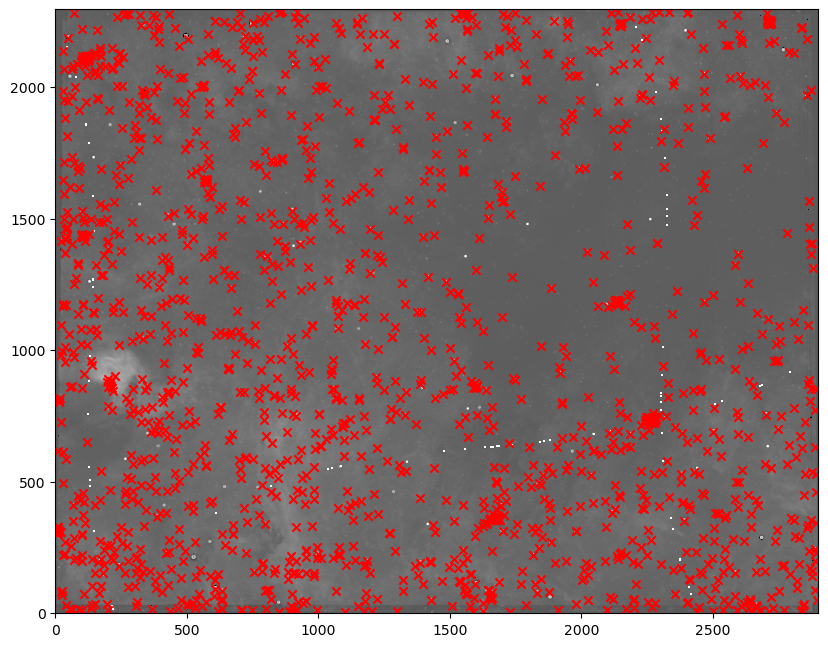

In [10]:
pl.imshow(data, norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [11]:
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel

In [12]:
def kill_star(cutout, radius, kernelwidth=1, nanneg=False, zeroneg=True):
    #print(cutout.size)
    cutoutcopy = cutout.copy()
    #print(cutoutcopy.size)
    yy, xx = np.indices(cutout.shape)
    #print("yy")
    rr2 = (xx - cutout.shape[1]/2)**2 + (yy - cutout.shape[0]/2)**2
    #print("rr2")
    msk = rr2 < radius**2
    # ignore negatives
    if nanneg:
        msk[cutoutcopy < 0] = np.nan
    #print('msksum: ',msk.sum())
    cutoutcopy[msk] = np.nan
    sm = convolve(cutoutcopy, Gaussian2DKernel(kernelwidth))
    sm[sm < 0] = 0
    cutoutcopy[msk] = sm[msk]
    return cutoutcopy

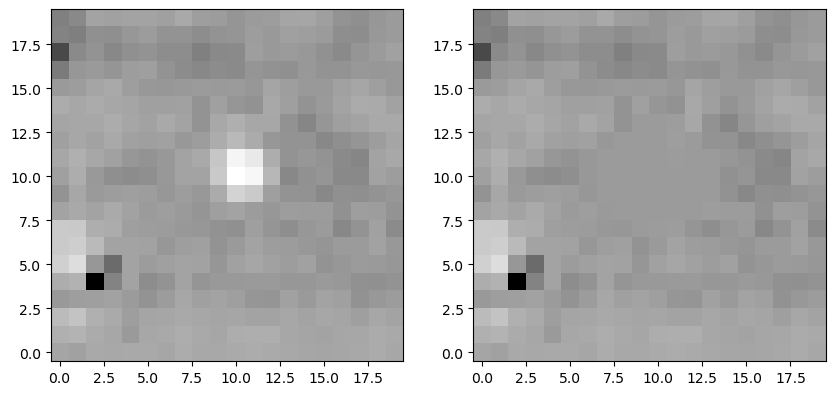

In [13]:
row = stars_bra[35]
sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
co = data[sy-10:sy+10, sx-10:sx+10]
pl.subplot(1,2,1).imshow(co, norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(kill_star(co, 3.5), norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')

In [14]:
from tqdm.notebook import tqdm

In [15]:
#datacopy = data.copy()

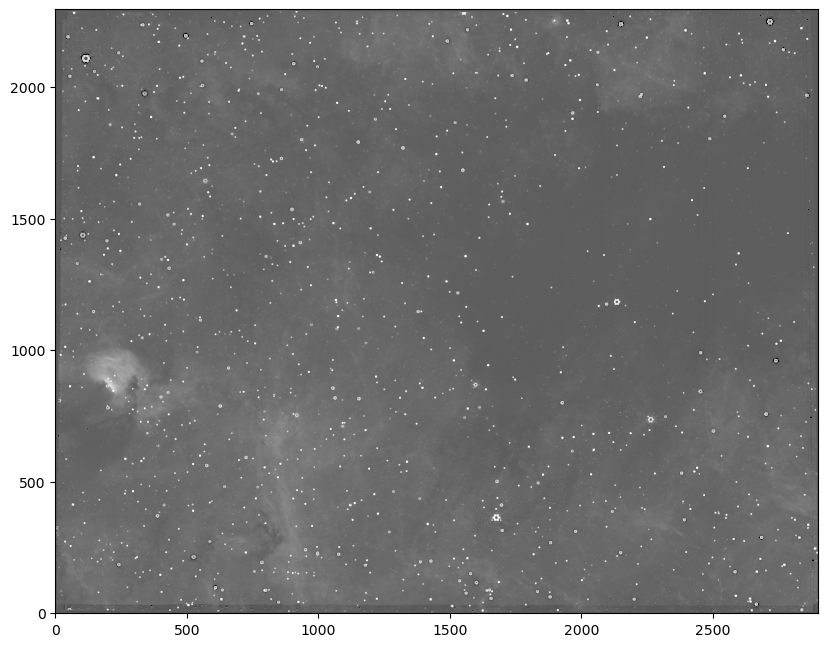

In [16]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [17]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())
assert not np.isnan(data[1054,645])

73


0it [00:00, ?it/s]

0


In [18]:
for row in tqdm(stars_bra):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/1627 [00:00<?, ?it/s]

In [19]:
np.isnan(data).sum()

0

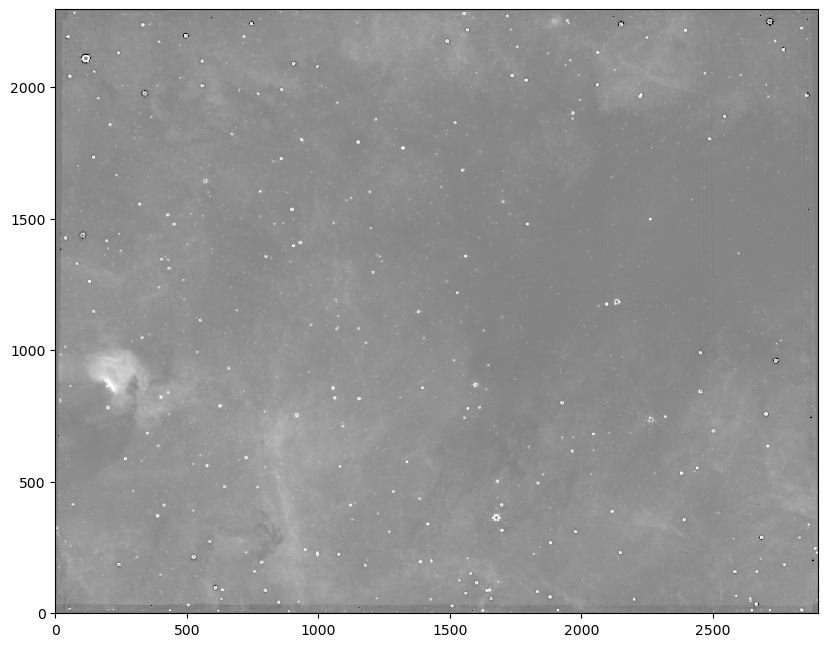

In [20]:
pl.imshow((data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [21]:
data[1054,645]

9.326560866810453

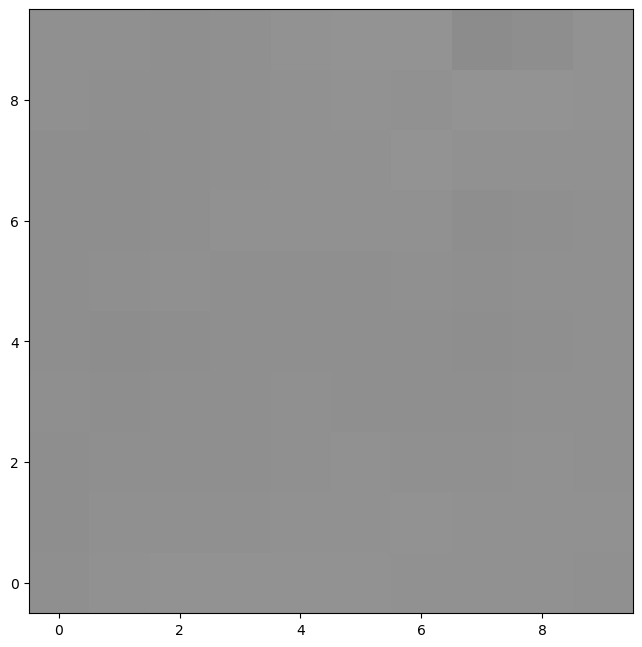

In [22]:
pl.imshow((data[1050:1060,640:650]), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [23]:
header = fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred.fits', overwrite=True)

In [24]:
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
stars_410 = DAOStarFinder(threshold=150, fwhm=2.302, peakmax=1000)(fh_410['SCI'].data)
len(stars_410)

6190

In [25]:
for row in tqdm(stars_410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

  0%|          | 0/6190 [00:00<?, ?it/s]

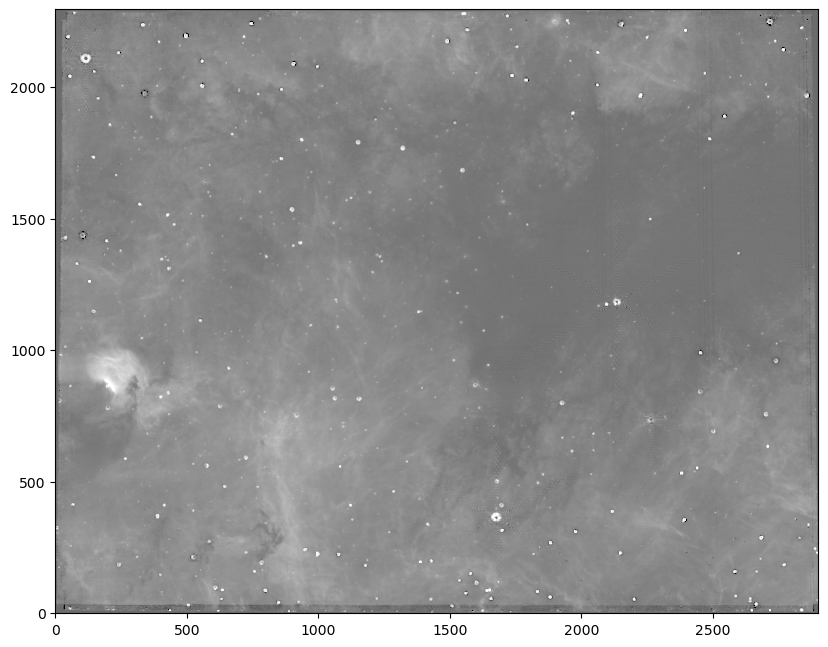

In [26]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [27]:
header = fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred2.fits', overwrite=True)

In [28]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits')
stars_bra_br = DAOStarFinder(threshold=2000, fwhm=2.302, peakmax=3e4)(fh_405['SCI'].data)
len(stars_bra_br)

434

In [29]:
for row in tqdm(stars_bra_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)

  0%|          | 0/434 [00:00<?, ?it/s]

In [30]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred3.fits', overwrite=True)

In [31]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred3.fits')

In [32]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 100, npixels=5)

In [33]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [34]:
# pixel coordinate of bright extended emission
xk,yk = 208,782

In [35]:
for row in tqdm(cat):
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 15 if row.area.value < 75 else 25
        rad_excise = 7.5 if row.area.value < 75 else 12.5
        rad_kernel = 2 if row.area.value < 75 else 4
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

  0%|          | 0/175 [00:00<?, ?it/s]

Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [93], [220.33880459 901.65003945]


In [36]:
import regions
regs = regions.Regions.read(f'{basepath}/regions/manual_destar_left_405.reg')

In [37]:
for reg in tqdm(regs):
    preg = reg.to_pixel(ww)
    mask = preg.to_mask()
    bbox = mask.bbox
    dx = 10
    bbox.ixmin -= dx
    bbox.iymin -= dx
    bbox.ixmax += dx
    bbox.iymax += dx
    co = data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax].copy()
    print(bbox, co.shape, data.shape, mask.data.shape)
    co[dx:-dx, dx:-dx][mask.data.astype('bool')] = np.nan
    msk = np.isnan(co)
    sm = convolve(co, Gaussian2DKernel(10))
    #sm[sm < 0] = 0
    co[msk] = sm[msk]
    data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax] = co

  0%|          | 0/18 [00:00<?, ?it/s]

RegionBoundingBox(ixmin=1642, ixmax=1705, iymin=326, iymax=407) (81, 63) (2296, 2901) (61, 43)
RegionBoundingBox(ixmin=1400, ixmax=1433, iymin=318, iymax=352) (34, 33) (2296, 2901) (14, 13)
RegionBoundingBox(ixmin=495, ixmax=555, iymin=187, iymax=239) (52, 60) (2296, 2901) (32, 40)
RegionBoundingBox(ixmin=71, ixmax=134, iymin=1405, iymax=1466) (61, 63) (2296, 2901) (41, 43)
RegionBoundingBox(ixmin=879, ixmax=918, iymin=1514, iymax=1560) (46, 39) (2296, 2901) (26, 19)
RegionBoundingBox(ixmin=548, ixmax=595, iymin=1618, iymax=1666) (48, 47) (2296, 2901) (28, 27)
RegionBoundingBox(ixmin=306, ixmax=370, iymin=1944, iymax=2008) (64, 64) (2296, 2901) (44, 44)
RegionBoundingBox(ixmin=537, ixmax=579, iymin=2080, iymax=2118) (38, 42) (2296, 2901) (18, 22)
RegionBoundingBox(ixmin=546, ixmax=589, iymin=1992, iymax=2024) (32, 43) (2296, 2901) (12, 23)
RegionBoundingBox(ixmin=480, ixmax=519, iymin=2184, iymax=2223) (39, 39) (2296, 2901) (19, 19)
RegionBoundingBox(ixmin=1525, ixmax=1571, iymin=1667,

In [38]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred4.fits', overwrite=True)

In [39]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred4.fits')

In [40]:
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
stars_410_f = DAOStarFinder(threshold=25, fwhm=2.302, peakmax=150)(fh_410['SCI'].data)
len(stars_410_f)

13316

In [41]:
for row in tqdm(stars_410_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/13316 [00:00<?, ?it/s]

In [42]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred5.fits', overwrite=True)

In [43]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred5.fits')

In [44]:
# Saturated in f410
stars_bra_sat410 = DAOStarFinder(threshold=500, fwhm=2.302, peakmax=3000)(fh_405['SCI'].data)
len(stars_bra_sat410)

1966

In [45]:
for row in tqdm(stars_bra_sat410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

  0%|          | 0/1966 [00:00<?, ?it/s]

In [46]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred6.fits', overwrite=True)

# Do it again for f466

In [47]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
np.isnan(data).sum()

98

In [48]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())
assert not np.isnan(data[1054,645]) #this check is for BrA...

98


0it [00:00, ?it/s]

0


In [49]:
data[data<0] = 0

In [50]:
stars_466 = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(data)
len(stars_466)

1626

In [51]:
for row in tqdm(stars_bra):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/1627 [00:00<?, ?it/s]

In [52]:
header = fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred.fits', overwrite=True)

In [53]:
for row in tqdm(stars_410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

  0%|          | 0/6190 [00:00<?, ?it/s]

In [54]:
header = fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred2.fits', overwrite=True)

In [55]:
fh_466 = fits.open(f'{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits')
stars_466_br = DAOStarFinder(threshold=2000, fwhm=2.302, peakmax=3e4)(fh_466['SCI'].data)
len(stars_466_br)

258

In [56]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred2.fits')

In [57]:
for row in tqdm(stars_466_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 30 and sy > 30 and sy < data.shape[0] - 30 and sx < data.shape[1] - 30:
        #co = data[sy-15:sy+15, sx-15:sx+15]
        #data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)
        co = data[sy-30:sy+30, sx-30:sx+30]
        data[sy-30:sy+30, sx-30:sx+30] = kill_star(co, 15, 5)

  0%|          | 0/258 [00:00<?, ?it/s]

In [58]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred3.fits', overwrite=True)

In [59]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred3.fits')

In [60]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 100, npixels=5)

In [61]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [62]:
# pixel coordinate of bright extended emission
xk,yk = 208,782

In [63]:
for row in tqdm(cat):
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 20 if row.area.value < 75 else 30
        rad_excise = 10 if row.area.value < 75 else 15
        rad_kernel = 2 if row.area.value < 75 else 4
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

  0%|          | 0/93 [00:00<?, ?it/s]

Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [57], [210.81417402 866.70457763]


In [64]:
import regions
regs = regions.Regions.read(f'{basepath}/regions/manual_destar_left_466.reg')

In [65]:
for reg in tqdm(regs):
    preg = reg.to_pixel(ww)
    mask = preg.to_mask()
    bbox = mask.bbox
    dx = 10
    bbox.ixmin -= dx
    bbox.iymin -= dx
    bbox.ixmax += dx
    bbox.iymax += dx
    co = data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax].copy()
    print(bbox, co.shape, data.shape, mask.data.shape)
    co[dx:-dx, dx:-dx][mask.data.astype('bool')] = np.nan
    msk = np.isnan(co)
    sm = convolve(co, Gaussian2DKernel(10))
    #sm[sm < 0] = 0
    co[msk] = sm[msk]
    data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax] = co

  0%|          | 0/17 [00:00<?, ?it/s]

RegionBoundingBox(ixmin=1965, ixmax=2325, iymin=1002, iymax=1374) (372, 360) (2296, 2901) (352, 340)
RegionBoundingBox(ixmin=2698, ixmax=2772, iymin=923, iymax=1000) (77, 74) (2296, 2901) (57, 54)
RegionBoundingBox(ixmin=2412, ixmax=2487, iymin=801, iymax=883) (82, 75) (2296, 2901) (62, 55)
RegionBoundingBox(ixmin=2216, ixmax=2299, iymin=698, iymax=783) (85, 83) (2296, 2901) (65, 63)
RegionBoundingBox(ixmin=1542, ixmax=1814, iymin=268, iymax=491) (223, 272) (2296, 2901) (203, 252)
RegionBoundingBox(ixmin=1881, ixmax=1964, iymin=758, iymax=843) (85, 83) (2296, 2901) (65, 63)
RegionBoundingBox(ixmin=1554, ixmax=1638, iymin=825, iymax=912) (87, 84) (2296, 2901) (67, 64)
RegionBoundingBox(ixmin=1050, ixmax=1103, iymin=215, iymax=253) (38, 53) (2296, 2901) (18, 33)
RegionBoundingBox(ixmin=466, ixmax=507, iymin=1053, iymax=1094) (41, 41) (2296, 2901) (21, 21)
RegionBoundingBox(ixmin=897, ixmax=937, iymin=1383, iymax=1426) (43, 40) (2296, 2901) (23, 20)
RegionBoundingBox(ixmin=866, ixmax=936,

In [66]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred4.fits', overwrite=True)

In [67]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred4.fits')

In [68]:
for row in tqdm(stars_410_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/13316 [00:00<?, ?it/s]

In [69]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred5.fits', overwrite=True)

In [70]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred5.fits')

In [71]:
# Saturated in f410
stars_466_sat410 = DAOStarFinder(threshold=500, fwhm=2.302, peakmax=3000)(fh_466['SCI'].data)
len(stars_466_sat410)

860

In [72]:
for row in tqdm(stars_466_sat410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

  0%|          | 0/860 [00:00<?, ?it/s]

In [73]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred6.fits', overwrite=True)

In [74]:
import pyavm
import PIL
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [75]:
rgb = np.array(
      [
       #fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits'),
       #fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits'),
       fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F410_minus_F405_nrca.fits')
      ]
).swapaxes(0,2).swapaxes(0,1)
#for layer in (0,1,2):
#    # desaturate stars (though this will whiten the edges!)
#    rgb[:,:,layer][np.isnan(rgb[:,:,layer])] = np.nanmax(rgb[:,:,layer])
#    rgb[:,:,layer][rgb[:,:,layer] == 0] = np.nanmax(rgb[:,:,layer])

In [76]:
AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/images/F410_minus_F405_nrca.fits'))
# AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits', ext=['SCI', 1]))

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [77]:
def save_rgb(img, filename):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::-1,:,:])
    img.save(filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


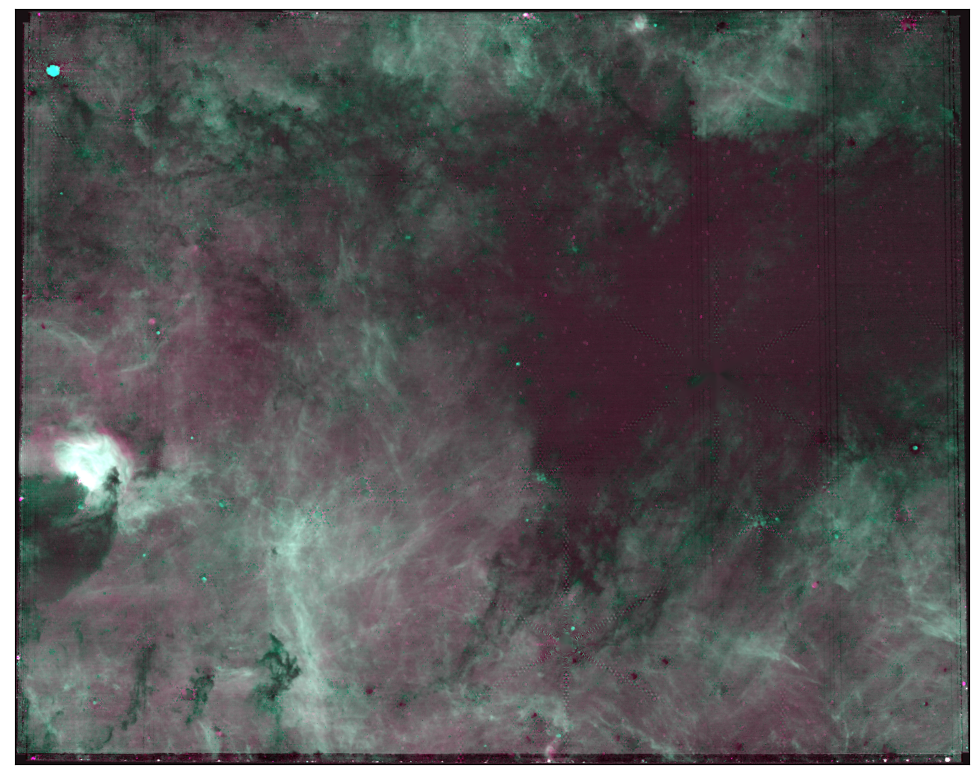

In [78]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-2, max_cut=70)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=100)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-4, max_cut=170)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
#hsv = rgb_to_hsv(rgb_scaled)
#hsv[:,:,0] += -0.35  # 0.25 = 90/360
#hsv[:,:,0] = hsv[:,:,0] % 1 
#rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_unrotated_lighter.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


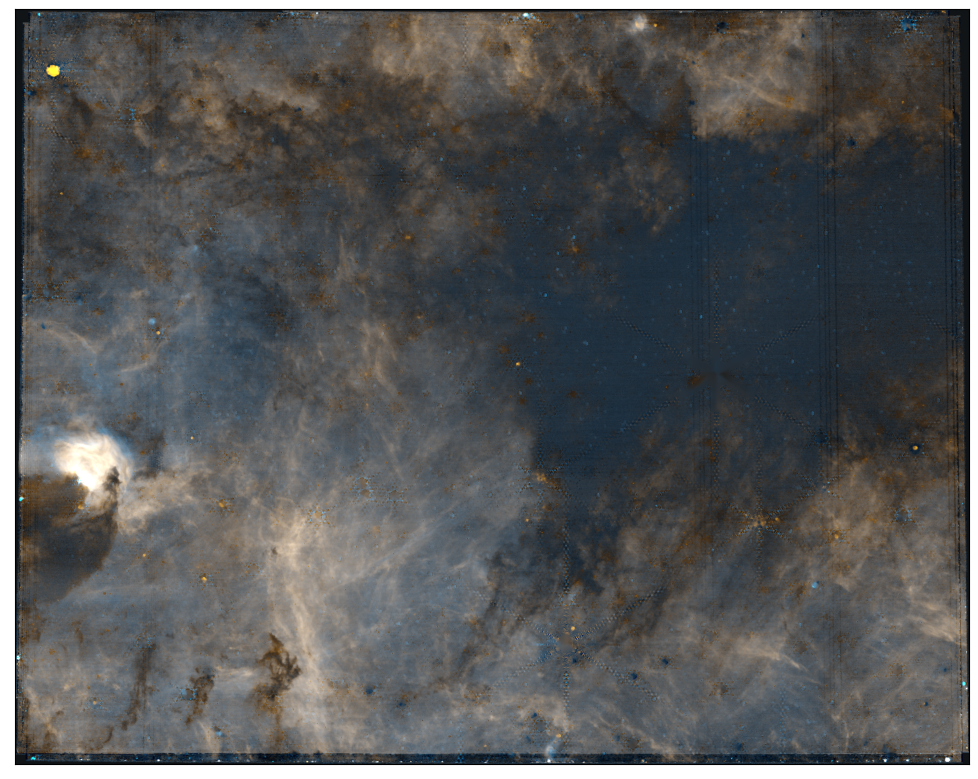

In [79]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-2, max_cut=70)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=100)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-4, max_cut=170)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

In [ ]:
PIL.Image.open(outfn)

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-2, max_cut=210)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)